# Data Science Challenge - BIPA

## Breno Brito

15/10/24

### Instruções

1. Use Python
2. Forneça comentários claros em seu código
3. Envie seu código, visualizações e um breve relatório explicando sua abordagem e resultados
4. Use o conjunto de dados "Bitcoin Historical Data" disponível no Kaggle https://www.kaggle.com/mczielinski/bitcoin-historical-data

### Entrega e Critérios de Avaliação

Após o termino, coloque seu projeto em um repositório público no Github ou Gitlab e envie o link pra gente. Ou se preferir, envie em um arquivo compactado por e-mail.

A Bipa irá avaliar seu conhecimento técnico, qualidade e organização do seu código, profundidade da análise e insights gerados, clareza na comunicação dos resultados e conhecimento demonstrado sobre Bitcoin e finanças.

Esperamos que você dê o seu melhor e consiga demonstrar todo seu conhecimento, em caso de dúvida, não hesite em nos contactar.

### Parte 1: Análise Exploratória de Dados

Usando o dataset do Kaggle:

1.2 Realize uma análise exploratória dos dados, incluindo estatísticas descritivas e visualizações relevantes.

1.2 Identifique e discuta quaisquer padrões ou tendências interessantes nos dados.

1.4 Proponha pelo menos duas hipóteses baseadas em suas observações que possam ser relevantes para o negócio da Bipa.



#### Primeiros ajustes e feature engineering

In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

def dateparse (time_in_secs):    
    if pd.isna(time_in_secs):
        return pd.NaT  # Return Not a Time for NaN values
    return datetime.datetime.fromtimestamp(float(time_in_secs))

path = "btcusd_1-min_data.csv"

df = pd.read_csv(path,parse_dates=[0],
                 date_parser=dateparse)
df.head()


/var/folders/vy/s9lbsy291glb0pzd3ynyjtrw0000gn/T/ipykernel_55629/2007030629.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(path,parse_dates=[0],


,Timestamp,Open,High,Low,Close,Volume
0,2012-01-01 08:01:00,4.58,4.58,4.58,4.58,0.0
1,2012-01-01 08:02:00,4.58,4.58,4.58,4.58,0.0
2,2012-01-01 08:03:00,4.58,4.58,4.58,4.58,0.0
3,2012-01-01 08:04:00,4.58,4.58,4.58,4.58,0.0
4,2012-01-01 08:05:00,4.58,4.58,4.58,4.58,0.0


In [243]:
df.tail()

,Timestamp,Open,High,Low,Close,Volume
6698276,2024-10-14 20:57:00,66056.0,66056.0,66056.0,66056.0,0.061340
6698277,2024-10-14 20:58:00,66054.0,66062.0,66054.0,66062.0,0.005927
6698278,2024-10-14 20:59:00,66070.0,66070.0,66070.0,66070.0,0.000480
6698279,2024-10-14 21:00:00,66070.0,66118.0,66070.0,66098.0,0.483483
6698280,NaT,57854.0,57864.0,57835.0,57835.0,1.353466


In [244]:
df.isnull().sum()

Timestamp    1
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64

In [370]:
# Como o único dado nulo é o último, podemos seguramente descartar
df.dropna(inplace=True)
df = df.sort_values('Timestamp', ascending=True).reset_index(drop=True)
df.tail()

,Timestamp,Open,High,Low,Close,Volume
6698275,2024-10-14 20:56:00,66065.0,66065.0,66065.0,66065.0,0.000370
6698276,2024-10-14 20:57:00,66056.0,66056.0,66056.0,66056.0,0.061340
6698277,2024-10-14 20:58:00,66054.0,66062.0,66054.0,66062.0,0.005927
6698278,2024-10-14 20:59:00,66070.0,66070.0,66070.0,66070.0,0.000480
6698279,2024-10-14 21:00:00,66070.0,66118.0,66070.0,66098.0,0.483483


In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6698280 entries, 0 to 6698279
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Timestamp  datetime64[ns]
 1   Open       float64       
 2   High       float64       
 3   Low        float64       
 4   Close      float64       
 5   Volume     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 306.6 MB


In [371]:
# Teste se todos os timestamps entre max e min existem
min_timestamp = df['Timestamp'].min()
max_timestamp = df['Timestamp'].max()
expected_timestamps = pd.date_range(start=min_timestamp, end=max_timestamp, freq='1min')
missing_timestamps = expected_timestamps.difference(df['Timestamp'])

if len(missing_timestamps) > 0:
    print(f"Faltam {len(missing_timestamps)} timestamps.")
    affected_days = pd.DataFrame(pd.to_datetime(missing_timestamps).date)[0]
    print(f'Número de dias afetados: {affected_days.drop_duplicates().size}.')
else:
    print("Todos timestamps presentes.")

Faltam 27780 timestamps.
Número de dias afetados: 49.


In [372]:
expected_df = pd.DataFrame({'Timestamp': expected_timestamps})

# full outer join
df_full = pd.merge(expected_df, df, on='Timestamp', how='outer')

# organizar por Timestamp para garantir o preenchimento foward fill
df_full = df_full.sort_values('Timestamp')
df_full = df_full.ffill()
df_full = df_full.reset_index(drop=True)
df = df_full

print(f"Novo formato: {df.shape}")


Novo formato: (6726060, 6)


Vamos entender sobre o que consiste o volume. Ele pode estar denominado em BTC ou em USD.

<Axes: title={'center': 'Volume em que moeda?'}, xlabel='Timestamp'>

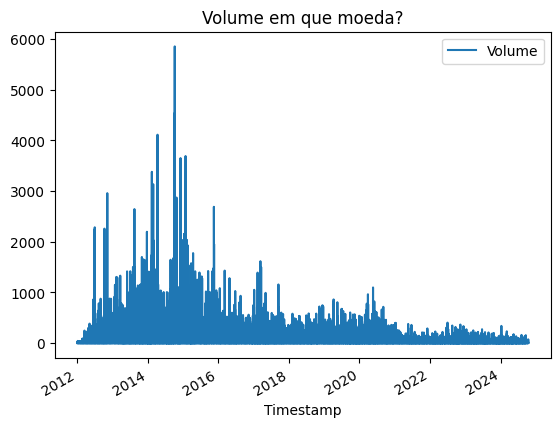

In [249]:
df.plot('Timestamp','Volume', title='Volume em que moeda?')

Claramente não está denominado em dólares, já que o volume cai com o tempo. Isso ocorre porque o preço do Bitcoin sobe, então o volume em bitcoins cai. Abaixo fica e faz muito mais sentido quando denominamos o volume em dólares.

<Axes: title={'center': 'Volume em USD'}, xlabel='Timestamp'>

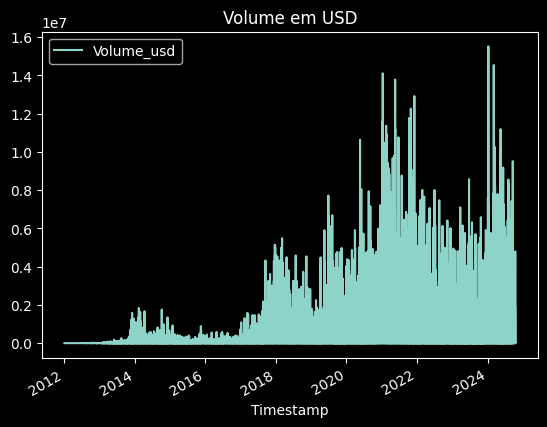

In [373]:
# O gráfico acima indica que o volume está denominado em bitcoins
# Vamos criar uma nova coluna que contenha o volume em dólares

df['Volume_usd'] = df['Volume'] * df['Close']
df.plot(x='Timestamp', y='Volume_usd', title='Volume em USD')

Tanto volume quando preço são variáveis que com distribuições não-normais e uma forma de facilitar o trabalho com elas é usar o logarítmo do preço e do volume.

In [374]:
# Faz sentido também criar o preço e volume em escala logarítmica
df['log_close'] = np.log(df['Close'])
df['log_volume_usd'] = np.log(df['Volume_usd'])


/Users/breno/Documents/code/SpiritOfSatoshi/ragtest/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='Timestamp'>

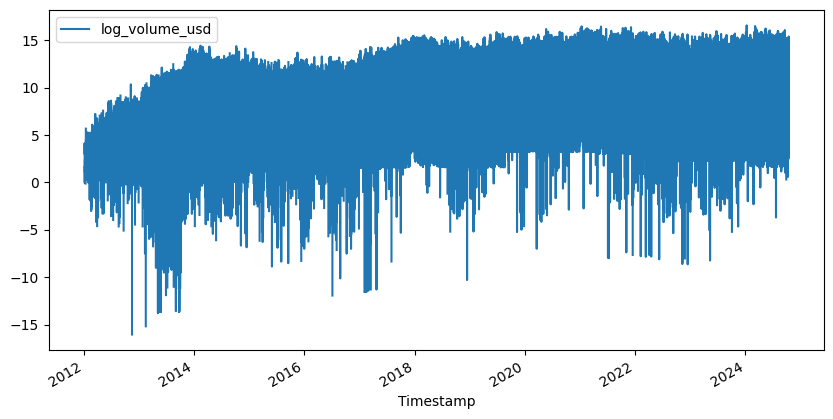

In [252]:
# Esse gráfico não parece tão útil
df.plot(x='Timestamp', y='log_volume_usd', figsize=(10,5))

Este gráfico ficou estranho por conta da granularidade. Diferente do preço – de certa forma –, o volume não tem nenhum compromisso com continuidade. Não sabemos de qual exchange foi retirado o dado e a granularidade baixa pode fazer com que em alguns minutos em alguns dias o volume seja baixo. Para ajustar isso, uma forma é agregar numa granularidade maior, como o dia.

Abaixo vemos que, apesar de ainda ser um dado ruidoso, a informação já está bem mais clara.

/Users/breno/Documents/code/SpiritOfSatoshi/ragtest/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: title={'center': 'Volume USD Diário em Escala Logarítmica'}, xlabel='Timestamp'>

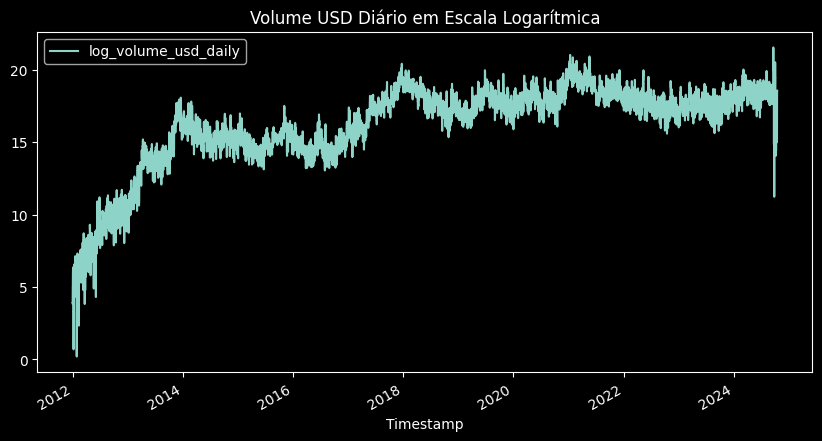

In [375]:
df['Volume_usd_daily'] = df.groupby(df['Timestamp'].dt.date)['Volume_usd'].transform('sum')
df['log_volume_usd_daily'] = np.log(df['Volume_usd_daily'])
df.plot(x='Timestamp', y='log_volume_usd_daily', title='Volume USD Diário em Escala Logarítmica', figsize=(10, 5))

Este formato do dado é interessante, vários picos e vales lembram os do próprio preço do bitcoin. Visualizando ambos juntos é possível entender que deve haver alguma correlação entre o preço e o volume.

Considerando a correlação, existem três hipóteses:
1. O volume é um indicador de preço adiantado; 
2. O volume é um indicador de preço atrasado (ou o preço é um idicador de volume); ou
3. Ambas variáveis são causadas por outra variável, o que faz ambas terem uma correlação, mas uma não causa a outra. 

In [376]:
# Feature engineering

df['month'] = df.Timestamp.dt.month
df['day'] = df.Timestamp.dt.day
df['weekday'] = df.Timestamp.dt.weekday
df['hour'] = df.Timestamp.dt.hour
df['minute'] = df.Timestamp.dt.minute

def get_cycle(row):
    if row['Timestamp'] < pd.Timestamp('2012-11-28'):
        return 1
    elif row['Timestamp'] < pd.Timestamp('2016-07-09'):
        return 2
    elif row['Timestamp'] < pd.Timestamp('2020-05-11'):
        return 3
    elif row['Timestamp'] < pd.Timestamp('2024-04-19'):
        return 4
    else:
        return 5

df['Cycle'] = df.apply(get_cycle, axis=1)

cycle_stats = df.groupby('Cycle').agg(
    peak_price=('High', 'max'),
    peak_date=('High', lambda x: df.loc[x.idxmax(), 'Timestamp']),
    # lowest_price=('Low', 'min'),
    # lowest_date=('Low', lambda x: df.loc[x.idxmin(), 'Timestamp'])
).reset_index()

# Para o menor preço, precisamos ver o ciclo de altas históricas
def get_ath_cycle(row):
    if row['Timestamp'] < cycle_stats['peak_date'].iloc[0]:
        return 1
    elif row['Timestamp'] < cycle_stats['peak_date'].iloc[1]:
        return 2
    elif row['Timestamp'] < cycle_stats['peak_date'].iloc[2]:
        return 3
    elif row['Timestamp'] < cycle_stats['peak_date'].iloc[3]:
        return 4
    else:
        return 5

df['ATH_cycle'] = df.apply(get_ath_cycle, axis=1)

cycle_ath_stats = df.groupby('ATH_cycle').agg(
    lowest_price=('Low', 'min'),
    lowest_date=('Low', lambda x: df.loc[x.idxmin(), 'Timestamp'])
).reset_index()

cycle_stats['lowest_price'] = cycle_ath_stats['lowest_price']
cycle_stats['lowest_date'] = cycle_ath_stats['lowest_date']

cycle_stats['log_peak_price'] = np.log(cycle_stats['peak_price'])
cycle_stats['log_lowest_price'] = np.log(cycle_stats['lowest_price'])

print(cycle_stats)

   Cycle  peak_price           peak_date  lowest_price         lowest_date  \
0      1       16.41 2012-08-17 09:12:00          3.80 2012-01-27 04:58:00   
1      2     1163.00 2013-11-30 06:36:00          7.10 2012-08-20 00:24:00   
2      3    19666.00 2017-12-17 15:25:00        152.40 2015-01-14 10:43:00   
3      4    73794.00 2024-03-14 08:05:00       3122.28 2018-12-15 18:51:00   
4      5    71958.00 2024-05-21 01:19:00      49577.00 2024-08-05 13:55:00   

   log_peak_price  log_lowest_price  
0        2.797891          1.335001  
1        7.058758          1.960095  
2        9.886647          5.026509  
3       11.209033          8.046319  
4       11.183838         10.811282  


In [256]:
cycle_stats['lowest_price'] = cycle_ath_stats['lowest_price']
cycle_stats['lowest_date'] = cycle_ath_stats['lowest_date']

cycle_stats['log_peak_price'] = np.log(cycle_stats['peak_price'])
cycle_stats['log_lowest_price'] = np.log(cycle_stats['lowest_price'])

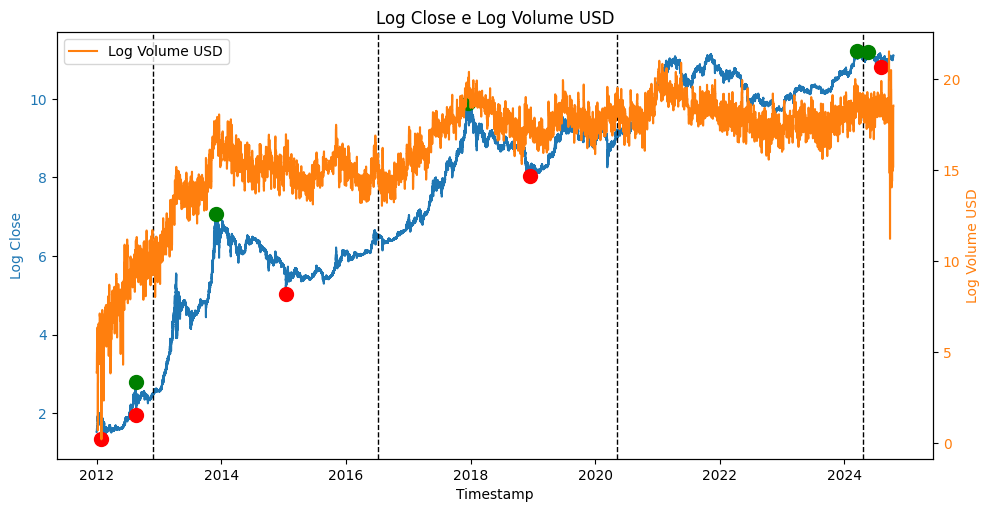

In [257]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Log Close', color='tab:blue')
ax1.plot(df['Timestamp'], df['log_close'], color='tab:blue', label='Log Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Adding vertical lines for each cycle change
for cycle_change in df[df['Cycle'].diff() != 0]['Timestamp'].iloc[1:]:
    ax1.axvline(x=cycle_change, color='black', linestyle='--', linewidth=1)

# Adding green circles for cycle peaks and red circles for lowest prices
for _, row in cycle_stats.iterrows():
    ax1.plot(row['peak_date'], row['log_peak_price'], 'go', markersize=10)  # Green circle for peak
    ax1.plot(row['lowest_date'], row['log_lowest_price'], 'ro', markersize=10)  # Red circle for lowest price

ax2 = ax1.twinx()
ax2.set_ylabel('Log Volume USD', color='tab:orange')
# ax2.plot(df['Timestamp'], df['Volume_usd'], color='tab:orange', label='Volume USD')
ax2.plot(df['Timestamp'], df['log_volume_usd_daily'], color='tab:orange', label='Log Volume USD')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Log Close e Log Volume USD')
plt.legend(loc='upper left')
plt.show()

#### Predição dos próximos maiores/menores retornos

A lei de Zipf diz que a frequência de uma palavra é inversamente proporcional ao seu posição ordenada num corpo textual em linguagem natural, ou seja, a frequência da segunda palavra mais presente é aproximadamente metade do primeira, a terceira um terço, e assim por diante. Anos depois, Mandelbrot criou a lei de Zipf generalizada, também conhecida como lei de Zipf-Mandelbrot, onde pode ser aplicada ao mercado financeiro relacionando a ordem de um retorno com sua magnitude.

Com essas informações, vamos visualizar o padrão que isto gera para o Bitcoin e com isso vamos prever o próximo maior salto de preços, similar à forma que poderíamos usar para prever a altura ideal de uma represa considerando o histórico de enchentes. Como pudemos ver recentemente na tragédia gaúcha, não basta se preparar para uma tragédia igual à pior anterior, é preciso de uma "folga", pois a máxima histórica sempre vai ser maior que a máxima histórica anterior. 

Mas quanto seria essa folga? Veremos abaixo.

In [258]:
def resample(df, period):
    # Calculate daily close and percentage returns while maintaining the timestamp
    resampled_df = df.set_index('Timestamp').resample(period).last()
    resampled_df['Open'] = df.set_index('Timestamp').resample(period).first()['Open']
    resampled_df['High'] = df.set_index('Timestamp').resample(period).max()['High']
    resampled_df['Low'] = df.set_index('Timestamp').resample(period).min()['Low']
    resampled_df['Volume'] = df.set_index('Timestamp').resample(period).sum()['Volume']
    resampled_df['Volume_usd'] = df.set_index('Timestamp').resample(period).sum()['Volume_usd']

    resampled_df['return'] = resampled_df['Close'].pct_change() * 100
    resampled_df['log_return'] = np.log(resampled_df['return'])
    return resampled_df.reset_index()

daily_df = resample(df, period='D')


/Users/breno/Documents/code/SpiritOfSatoshi/ragtest/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/breno/Documents/code/SpiritOfSatoshi/ragtest/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [259]:

# Create Zipf plot
zipf_data_p = daily_df[daily_df['return'] > 0]['return'].sort_values(ascending=False).reset_index(drop=True).reset_index(drop=False)
# zipf_data_p = zipf_data_p[zipf_data_p['return'] > 0]  # Filter to keep only positive returns
zipf_data_n = daily_df[daily_df['return'] < 0]['return'].sort_values(ascending=True).reset_index(drop=True).reset_index(drop=False)
# zipf_data_p = zipf_data_n[zipf_data_n['return'] < 0]  # Filter to keep only positive returns
zipf_data_p['rank'] = zipf_data_p['index'] + 1
zipf_data_n['rank'] = zipf_data_n['index'] + 1
zipf_data_p.drop(columns='index', inplace=True)
zipf_data_n.drop(columns='index', inplace=True)
zipf_data_p['log_rank'] = np.log(zipf_data_p['rank'])
zipf_data_n['log_rank'] = np.log(zipf_data_n['rank'])
zipf_data_p['log_return'] = np.log(zipf_data_p['return'])
zipf_data_n['log_return'] = np.log(abs(zipf_data_n['return']))


In [260]:
zipf_data_p.head()

,return,rank,log_rank,log_return
0,45.038168,1,0.000000,3.807510
1,29.932964,2,0.693147,3.398960
2,26.035426,3,1.098612,3.259458
3,25.128205,4,1.386294,3.223991
4,24.752828,5,1.609438,3.208940


<Axes: xlabel='log_return', ylabel='log_rank'>

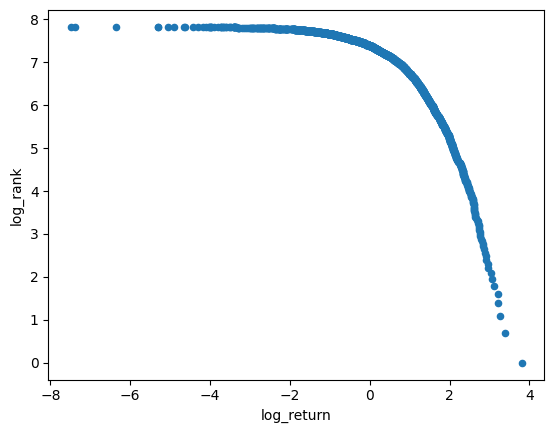

In [261]:
zipf_data_p.plot(kind='scatter', y='log_rank', x='log_return')

Aqui podemos ver que quanto mais se aproxima dos maiores retornos históricos, a curva assume uma direção clara. Essa é a cauda direita da distribuição de retornos do bitcoin, e a inclinação da linha que vamos traçar no próximo gráfico é justamente o parâmetro $-\alpha$ da distribuição de Pareto. 

Esse gráfico nos possibilita "dar um zoom" no final da cauda direita, o que é simultaneamente onde temos menos informação, mas é a parte mais relevante da distribuição.

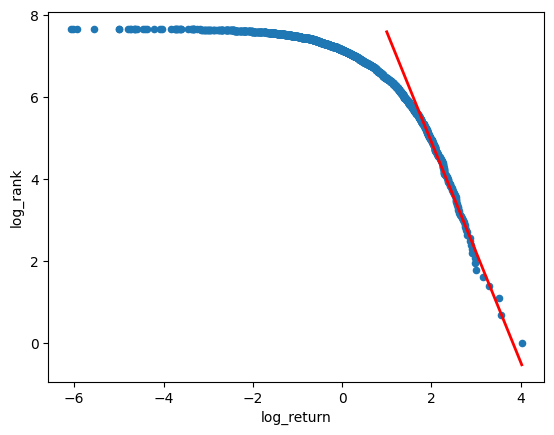

A inclinação da regressão linear: -2.68


In [262]:
from sklearn.linear_model import LinearRegression

# Prepara dados
X = zipf_data_n['log_return'].head(50).values.reshape(-1, 1)
y = zipf_data_n['log_rank'].head(50).values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Extract the slope
slope = model.coef_[0]

# Plot the original scatter plot
zipf_data_n.plot(kind='scatter', y='log_rank', x='log_return')

# Extend the linear regression line up to the highest log_rank value
X_extended = np.linspace(X.max(), 1, 100).reshape(-1, 1)
plt.plot(X_extended, model.predict(X_extended), color='red', linewidth=2)

# Show the plot
plt.show()

# Print the slope
print(f"A inclinação da regressão linear: {slope:.2f}")


O último pior retorno da história foi -55.98% e o próximo pior retorno diário da história será: -55.57% ± 28.96%


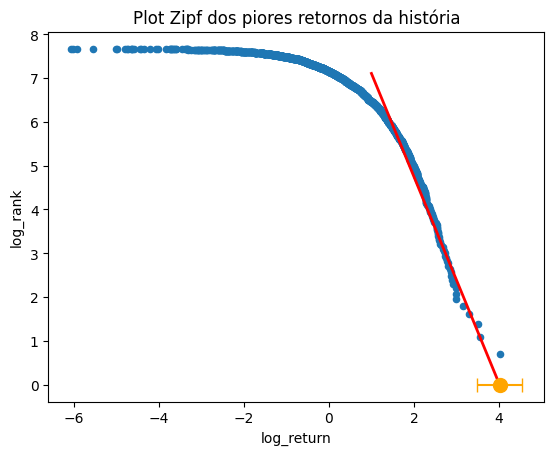

In [263]:
# Qual seria o próximo menor retorno diário da história?
if zipf_data_p['rank'].iloc[0] == 1:
    zipf_data_p['rank'] = zipf_data_p['rank'] + 1 # O maior, vira segundo maior
    zipf_data_n['rank'] = zipf_data_n['rank'] + 1 # O menor, vira segundo menor
elif zipf_data_p['rank'].iloc[0] != 2:
    raise ValueError(f"Ajustar ranking. O maior agora é {zipf_data_p['rank'].iloc[0]}")

zipf_data_p['log_rank'] = np.log(zipf_data_p['rank'])
zipf_data_n['log_rank'] = np.log(zipf_data_n['rank'])

# O próximo pior retorno histórico 
X = zipf_data_n['log_return'].head(50).values.reshape(-1, 1)
y = zipf_data_n['log_rank'].head(50).values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)
# Extract the slope
slope = model.coef_[0]
intercept = model.intercept_

zipf_data_n.plot(kind='scatter', y='log_rank', x='log_return')
X_extended = np.linspace(-intercept/slope, 1, 100).reshape(-1, 1)
plt.plot(X_extended, model.predict(X_extended), color='red', linewidth=2)

plt.title('Plot Zipf dos piores retornos da história')

# Achando o erro através de bootstrapping
# Com apenas 5 valores, a regressão estará sensível à variação do último dado

X = zipf_data_n['log_return'].head(5).values.reshape(-1, 1)
y = zipf_data_n['log_rank'].head(5).values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)
# Extract the slope
slope_err = model.coef_[0]
intercept_err = model.intercept_

error = abs((-intercept_err/slope_err) - (-intercept/slope))

plt.errorbar(-intercept/slope, 0, xerr=error, yerr=0.0, fmt='o-', 
             color='orange', markersize=10, capsize=5)  

print(f"O último pior retorno da história foi {zipf_data_n['return'].iloc[0]:.2f}% e o próximo pior retorno diário da história será: -{np.exp(-intercept/slope):.2f}% ± {np.exp(-intercept/slope) * error:.2f}%")


O maior retorno diário da história foi de 45.04% e o próximo maior retorno diário da história será em torno de: 44.52% ± 17.72%


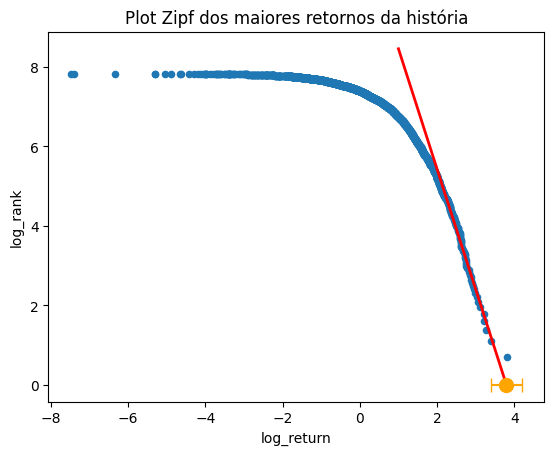

In [264]:
# Qual seria o próximo maior retorno histórico?
if zipf_data_p['rank'].iloc[0] == 1:
    zipf_data_p['rank'] = zipf_data_p['rank'] + 1 # O maior, vira segundo maior
    zipf_data_n['rank'] = zipf_data_n['rank'] + 1 # O menor, vira segundo menor
elif zipf_data_p['rank'].iloc[0] != 2:
    raise ValueError(f"Ajustar ranking. O maior agora é {zipf_data_p['rank'].iloc[0]}")

zipf_data_p['log_rank'] = np.log(zipf_data_p['rank'])
zipf_data_n['log_rank'] = np.log(zipf_data_n['rank'])

# O próximo pior retorno histórico 
X = zipf_data_p['log_return'].head(50).values.reshape(-1, 1)
y = zipf_data_p['log_rank'].head(50).values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)
# Extract the slope
slope = model.coef_[0]
intercept = model.intercept_

zipf_data_p.plot(kind='scatter', y='log_rank', x='log_return')
X_extended = np.linspace(-intercept/slope, 1, 100).reshape(-1, 1)
plt.plot(X_extended, model.predict(X_extended), color='red', linewidth=2)

plt.title('Plot Zipf dos maiores retornos da história')

# Achando o erro através de bootstrapping
# Com apenas 5 valores, a regressão estará sensível à variação do último dado

X = zipf_data_p['log_return'].head(5).values.reshape(-1, 1)
y = zipf_data_p['log_rank'].head(5).values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)
# Extract the slope
slope_err = model.coef_[0]
intercept_err = model.intercept_

error = abs((-intercept_err/slope_err) - (-intercept/slope))

plt.errorbar(-intercept/slope, 0, xerr=error, yerr=0.0, fmt='o-', 
             color='orange', markersize=10, capsize=5)  

print(f"O maior retorno diário da história foi de {zipf_data_p['return'].iloc[0]:.2f}% e o próximo maior retorno diário da história será em torno de: {np.exp(-intercept/slope):.2f}% ± {np.exp(-intercept/slope) * error:.2f}%")

In [265]:
# Vamos refazer, mas para o 5o. ciclo do Bitcoin 

# Create Zipf plot
zipf_data_p = daily_df[(daily_df['return'] > 0) & (daily_df['Cycle'] == 5)]['return'].sort_values(ascending=False).reset_index(drop=True).reset_index(drop=False)
# zipf_data_p = zipf_data_p[zipf_data_p['return'] > 0]  # Filter to keep only positive returns
zipf_data_n = daily_df[(daily_df['return'] < 0) & (daily_df['Cycle'] == 5)]['return'].sort_values(ascending=True).reset_index(drop=True).reset_index(drop=False)
# zipf_data_p = zipf_data_n[zipf_data_n['return'] < 0]  # Filter to keep only positive returns
zipf_data_p['rank'] = zipf_data_p['index'] + 1
zipf_data_n['rank'] = zipf_data_n['index'] + 1
zipf_data_p.drop(columns='index', inplace=True)
zipf_data_n.drop(columns='index', inplace=True)
zipf_data_p['log_rank'] = np.log(zipf_data_p['rank'])
zipf_data_n['log_rank'] = np.log(zipf_data_n['rank'])
zipf_data_p['log_return'] = np.log(zipf_data_p['return'])
zipf_data_n['log_return'] = np.log(abs(zipf_data_n['return']))


O último pior retorno diário do ciclo foi -6.80% e o próximo pior retorno diário do ciclo será em torno de: -10.60% ± 3.11%


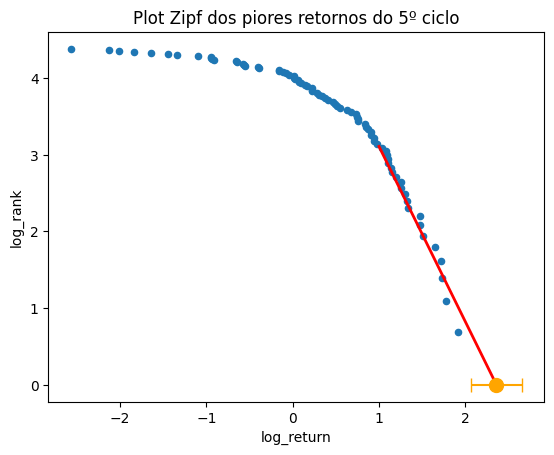

In [266]:
# Qual seria o próximo menor retorno diário do ciclo?
if zipf_data_p['rank'].iloc[0] == 1:
    zipf_data_p['rank'] = zipf_data_p['rank'] + 1 # O maior, vira segundo maior
    zipf_data_n['rank'] = zipf_data_n['rank'] + 1 # O menor, vira segundo menor
elif zipf_data_p['rank'].iloc[0] != 2:
    raise ValueError(f"Ajustar ranking. O maior agora é {zipf_data_p['rank'].iloc[0]}")

zipf_data_p['log_rank'] = np.log(zipf_data_p['rank'])
zipf_data_n['log_rank'] = np.log(zipf_data_n['rank'])

# O próximo pior retorno histórico 
X = zipf_data_n['log_return'].head(30).values.reshape(-1, 1)
y = zipf_data_n['log_rank'].head(30).values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)
# Extract the slope
slope = model.coef_[0]
intercept = model.intercept_

zipf_data_n.plot(kind='scatter', y='log_rank', x='log_return')
X_extended = np.linspace(-intercept/slope, 1, 100).reshape(-1, 1)
plt.plot(X_extended, model.predict(X_extended), color='red', linewidth=2)

# Add title to the plot
plt.title('Plot Zipf dos piores retornos do 5º ciclo')

# Achando o erro através de bootstrapping
# Com apenas 5 valores, a regressão estará sensível à variação do último dado

X = zipf_data_n['log_return'].head(5).values.reshape(-1, 1)
y = zipf_data_n['log_rank'].head(5).values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)
# Extract the slope
slope_err = model.coef_[0]
intercept_err = model.intercept_

error = abs((-intercept_err/slope_err) - (-intercept/slope))

plt.errorbar(-intercept/slope, 0, xerr=error, yerr=0.0, fmt='o-', 
             color='orange', markersize=10, capsize=5)  

# Print the slope
print(f"O último pior retorno diário do ciclo foi {zipf_data_n['return'].iloc[0]:.2f}% e o próximo pior retorno diário do ciclo será em torno de: -{np.exp(-intercept/slope):.2f}% ± {np.exp(-intercept/slope) * error:.2f}%")


O maior retorno diário do 5º ciclo foi de 12.76% e o próximo maior retorno diário do 5º ciclo será em torno de: 17.03% ± 3.39%


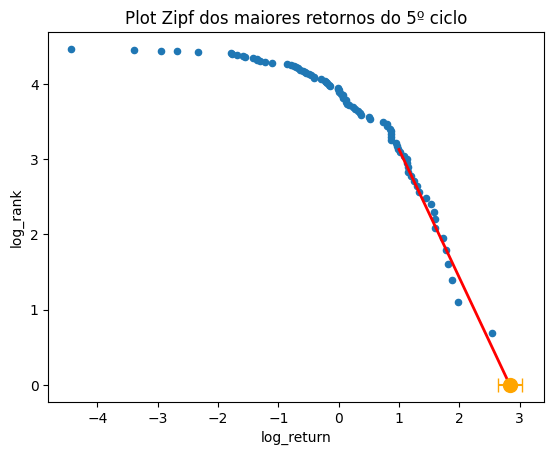

In [267]:
# Qual seria o próximo maior retorno histórico?
if zipf_data_p['rank'].iloc[0] == 1:
    zipf_data_p['rank'] = zipf_data_p['rank'] + 1 # O maior, vira segundo maior
    zipf_data_n['rank'] = zipf_data_n['rank'] + 1 # O menor, vira segundo menor
elif zipf_data_p['rank'].iloc[0] != 2:
    raise ValueError(f"Ajustar ranking. O maior agora é {zipf_data_p['rank'].iloc[0]}")

zipf_data_p['log_rank'] = np.log(zipf_data_p['rank'])
zipf_data_n['log_rank'] = np.log(zipf_data_n['rank'])

# O próximo pior retorno histórico 
X = zipf_data_p['log_return'].head(30).values.reshape(-1, 1)
y = zipf_data_p['log_rank'].head(30).values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)
# Extract the slope
slope = model.coef_[0]
intercept = model.intercept_

zipf_data_p.plot(kind='scatter', y='log_rank', x='log_return')
X_extended = np.linspace(-intercept/slope, 1, 100).reshape(-1, 1)
plt.plot(X_extended, model.predict(X_extended), color='red', linewidth=2)

# Add title to the plot
plt.title('Plot Zipf dos maiores retornos do 5º ciclo')

# Achando o erro através de bootstrapping
# Com apenas 5 valores, a regressão estará sensível à variação do último dado

X = zipf_data_p['log_return'].head(5).values.reshape(-1, 1)
y = zipf_data_p['log_rank'].head(5).values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)
# Extract the slope
slope_err = model.coef_[0]
intercept_err = model.intercept_

error = abs((-intercept_err/slope_err) - (-intercept/slope))

plt.errorbar(-intercept/slope, 0, xerr=error, yerr=0.0, fmt='o-', 
             color='orange', markersize=10, capsize=5)  

# Print the slope
print(f"O maior retorno diário do 5º ciclo foi de {zipf_data_p['return'].iloc[0]:.2f}% e o próximo maior retorno diário do 5º ciclo será em torno de: {np.exp(-intercept/slope):.2f}% ± {np.exp(-intercept/slope) * error:.2f}%")

#### Sazonalidade

/Users/breno/Documents/code/SpiritOfSatoshi/ragtest/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/breno/Documents/code/SpiritOfSatoshi/ragtest/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


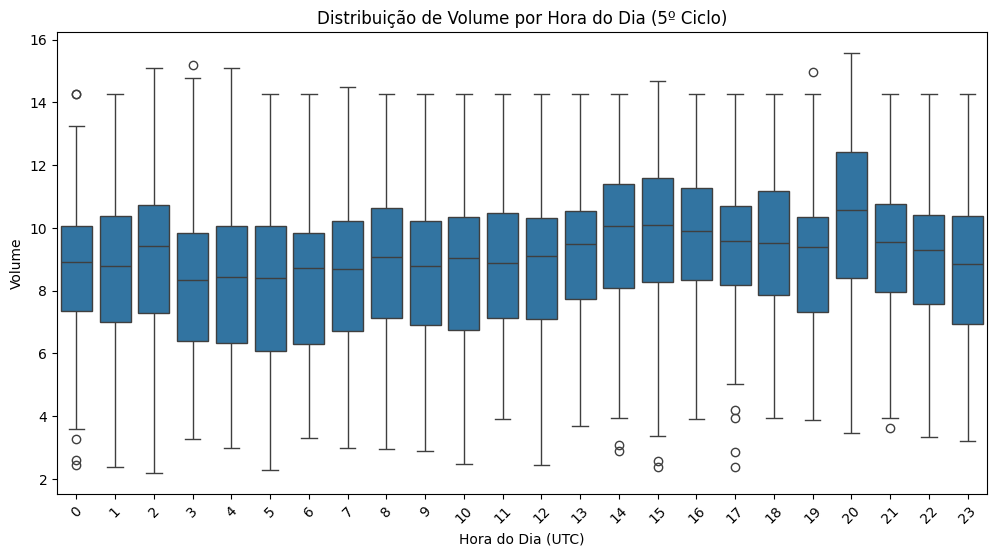

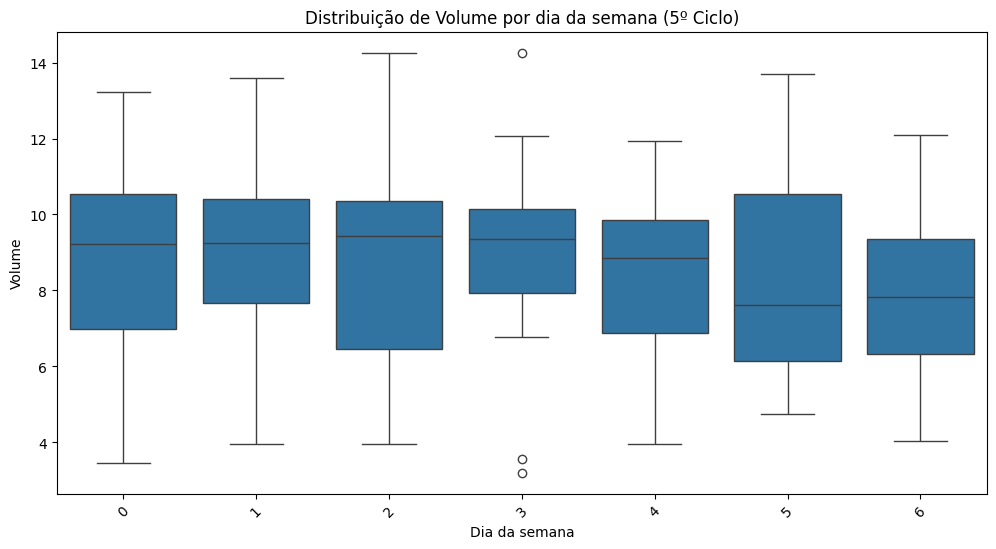

/Users/breno/Documents/code/SpiritOfSatoshi/ragtest/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


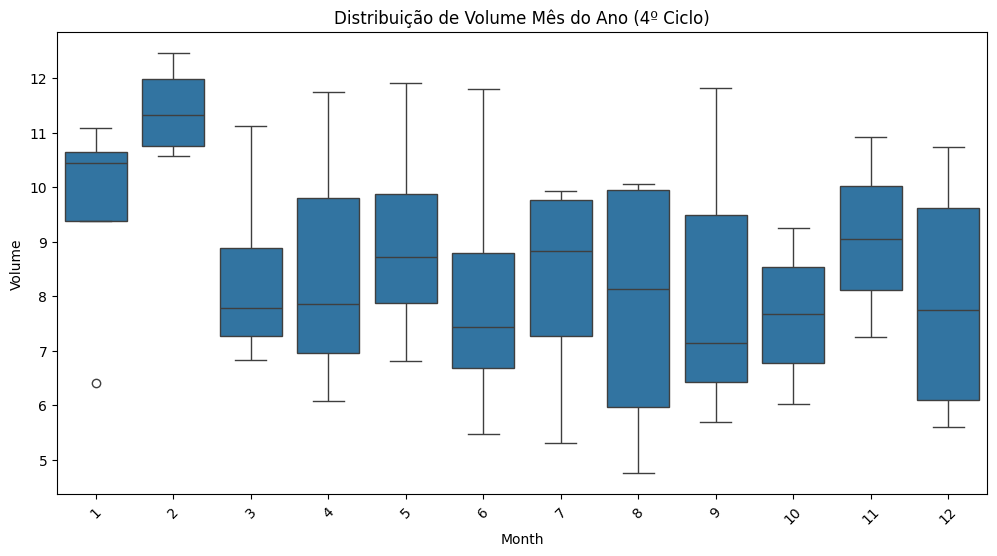

In [268]:
import seaborn as sns

daily_df['Timestamp'] = pd.to_datetime(daily_df['Timestamp'])
houry_df = resample(df, period='H')

# Boxplot for volume during hours of the day for the 5th cycle
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='log_volume_usd', data=houry_df[houry_df['Cycle'] == 5])
plt.title('Distribuição de Volume por Hora do Dia (5º Ciclo)')
plt.xlabel('Hora do Dia (UTC)')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.show()

# Boxplot for volume during days of the week for the 5th cycle
plt.figure(figsize=(12, 6))
sns.boxplot(x='weekday', y='log_volume_usd', data=daily_df[daily_df['Cycle'] == 5])
plt.title('Distribuição de Volume por dia da semana (5º Ciclo)')
plt.xlabel('Dia da semana')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.show()

monthly_df = resample(df, period='M')
# Boxplot for volume during months of the year for the 4th cycle
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='log_volume_usd', data=monthly_df[monthly_df['Cycle'] == 4])
plt.title('Distribuição de Volume Mês do Ano (4º Ciclo)')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.show()


Os dados acima mostram que há um volume de trading consideravelmente maior nos meses de janeiro e fevereiro, muito possivelmente devido ao final do ano fiscal e período de imposto de renda. 

Além disso é possível ver que o volume é menor no final de semana (dias 5 e 6), o que mostra a existência dos players institucionais.

O volume também é muito maior entre 20h-21h UTC, o que provavelmente é devido ao fechamento de mercado americano, que ocorre às 21h UTC ou 20h UTC caso seja horário de verão. Este é um horário de consolidação de carteiras e encerramento de transações no TradFi, e também quando daytraders encerram suas posições para não dormirem expostos.

Abaixo vamos analisar a sazonalidade do preço.

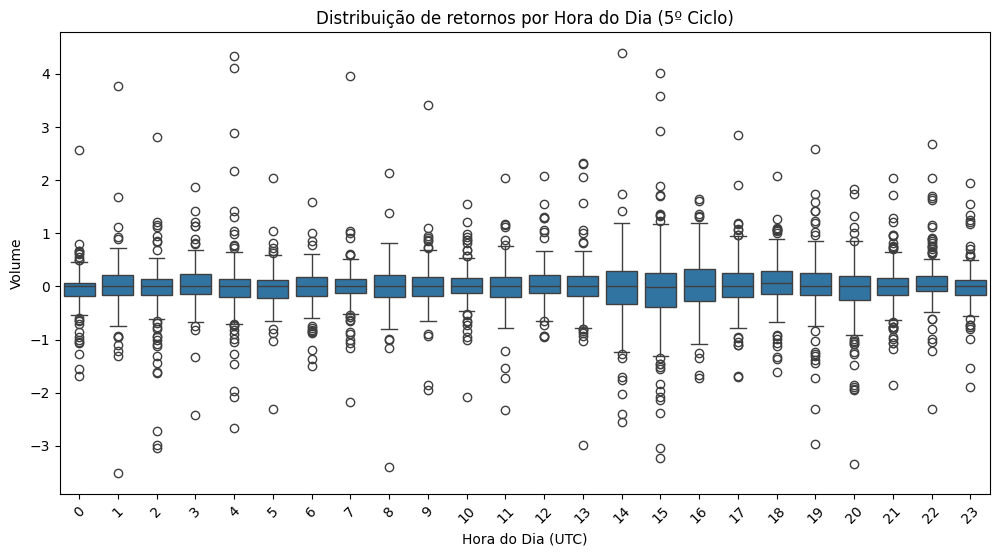

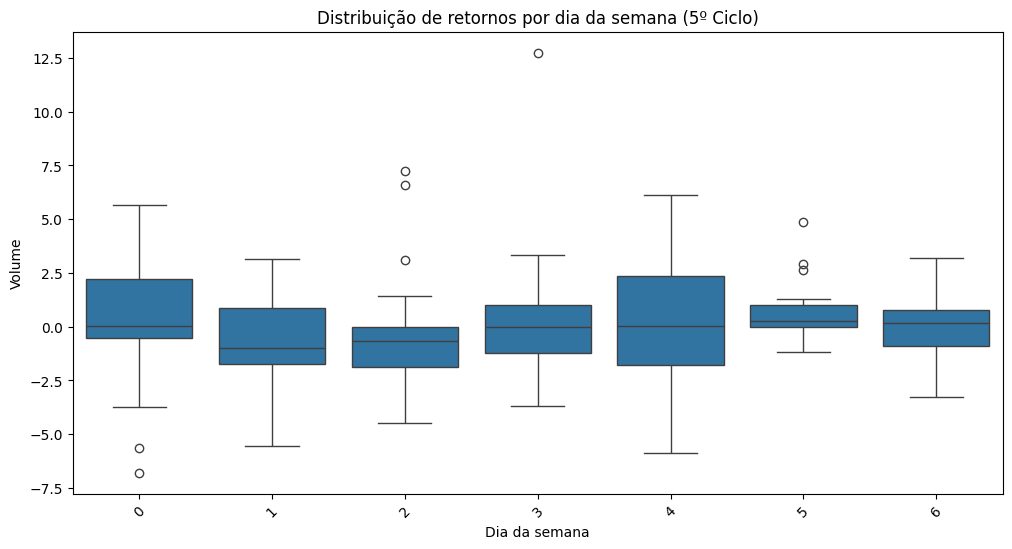

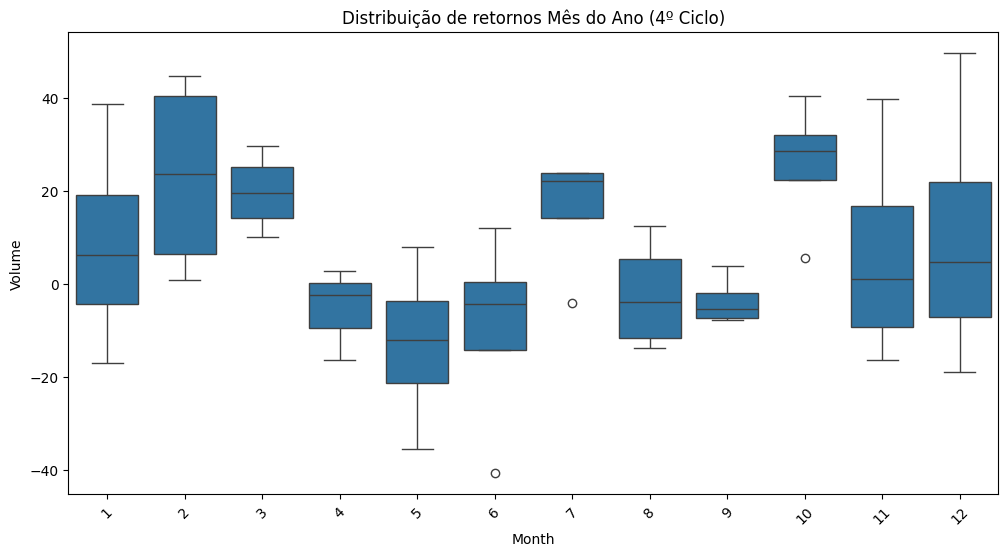

In [269]:
# Boxplot for volume during hours of the day for the 5th cycle
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='return', data=houry_df[houry_df['Cycle'] == 5])
plt.title('Distribuição de retornos por Hora do Dia (5º Ciclo)')
plt.xlabel('Hora do Dia (UTC)')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.show()

# Boxplot for volume during days of the week for the 5th cycle
plt.figure(figsize=(12, 6))
sns.boxplot(x='weekday', y='return', data=daily_df[daily_df['Cycle'] == 5])
plt.title('Distribuição de retornos por dia da semana (5º Ciclo)')
plt.xlabel('Dia da semana')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.show()

# Boxplot for volume during months of the year for the 4th cycle
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='return', data=monthly_df[monthly_df['Cycle'] == 4])
plt.title('Distribuição de retornos Mês do Ano (4º Ciclo)')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.show()


À primeira vista, não é possível observar nenhum efeito relevante nos horários do dia para o 5º ciclo, provavelmente devido à adoção profissional e profissionalização da indústria.

Para quem faz trades semanais, terça e quarta-feira (dias 1 e 2) são os dias onde a média de preços está mais abaixo. Uma possível estratégia seria comprar na quarta e vender no final da semana.

O mais interessante é o comportamento mensal no 4º ciclo, onde podemos ver claramente o efeito Uptober de outubro. Temos um efeito similar também em julho.

### Parte 2: Modelagem Preditiva

2.1 Desenvolva um modelo para prever o preço e volume do Bitcoin nas próximas 24 horas.

2.2 Avalie o desempenho do seu modelo usando métricas apropriadas.

2.3 Discuta as features mais importantes do seu modelo e por quê.

2.4 Sugira como este modelo poderia ser usado para melhorar os serviços da Bipa para seus clientes.



#### Modelagem Preditiva

Prever o preço do Bitcoin das 24h seguintes é uma tarefa perto de impossível. Se fosse simples, ficar milionário com trade seria fácil. Mesmo os profissionais mais qualificados do mercado não tentam prever o preço de um ativo com precisão, mas tentam prever a probabilidade de um determinado trade dar lucro, que é outra coisa.

Entretanto, para o propósito deste exercício, vamos criar um modelo simples para fazer uma previsão e avaliar suas métricas.

In [282]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Feature engineering
df['fut_return_24h'] = df['Close'].pct_change(periods=24*60).shift(-24*60)
df['log_return'] = np.log(df['Close'] / df['Close'].shift(24*60))
df['volatility'] = df['log_return'].rolling(window=24*60).std()
df['volume_ma'] = df['log_volume_usd'].rolling(window=24*60).mean()
df['volume_ma_perc'] = df['volume_ma'] / df['log_volume_usd']
df['volume_vol'] = df['Volume'].rolling(window=24*60).std()
df['monthly_ma'] = df['Close'].rolling(window=30*24*60).mean()
df['monthly_ma_perc'] = df['monthly_ma'] / df['Close']
df['weekly_ma'] = df['Close'].rolling(window=7*24*60).mean()
df['weekly_ma_perc'] = df['weekly_ma'] / df['Close']
df['daily_ma'] = df['Close'].rolling(window=24*60).mean()
df['daily_ma_perc'] = df['daily_ma'] / df['Close']


df = df.dropna()

# Define features and target
features = ['log_return', 'volatility', 'volume_ma_perc', 'volume_vol',
            'monthly_ma_perc', 'weekly_ma_perc', 'daily_ma_perc',
            'weekday', 'month', 'day', 'Cycle']
X = df[features]
y = df['fut_return_24h']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Especificar variáveis categóricas para o OneHotEncoder
known_categories = {
    'weekday': [0, 1, 2, 3, 4, 5, 6],  # Monday (0) to Sunday (6)
    'month': list(range(1, 13)),       # January (1) to December (12)
    'day': list(range(1, 32)),         # dias do mês (1 to 31)
    'Cycle': list(range(1, 6))         # 
}

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories=[known_categories['weekday'], 
                                          known_categories['month'], 
                                          known_categories['day'],
                                          known_categories['Cycle']], 
                              handle_unknown='ignore'), 
         ['weekday', 'month', 'day', 'Cycle']),
    ],
    remainder='passthrough'  # Leave continuous features unchanged
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor())
])

# Hiperparâmetros para a busca no RandomizedSearchCV
param_distributions = {
    'model__n_estimators': np.arange(50, 300, 50),
    'model__max_depth': [5, 10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}

# Split the data
tscv = TimeSeriesSplit(n_splits=3)

random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=3,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error', 
    cv=tscv, 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters found:  {'model__n_estimators': 250, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 5}


Test Set MSE: 0.13

Feature Importance:
            feature  importance
15          month_9    0.309366
61    daily_ma_perc    0.206153
59  monthly_ma_perc    0.191780
11          month_5    0.106016
56       volatility    0.066461
58       volume_vol    0.055960
23            day_5    0.027370
55       log_return    0.024015
6         weekday_6    0.004795
60   weekly_ma_perc    0.002844


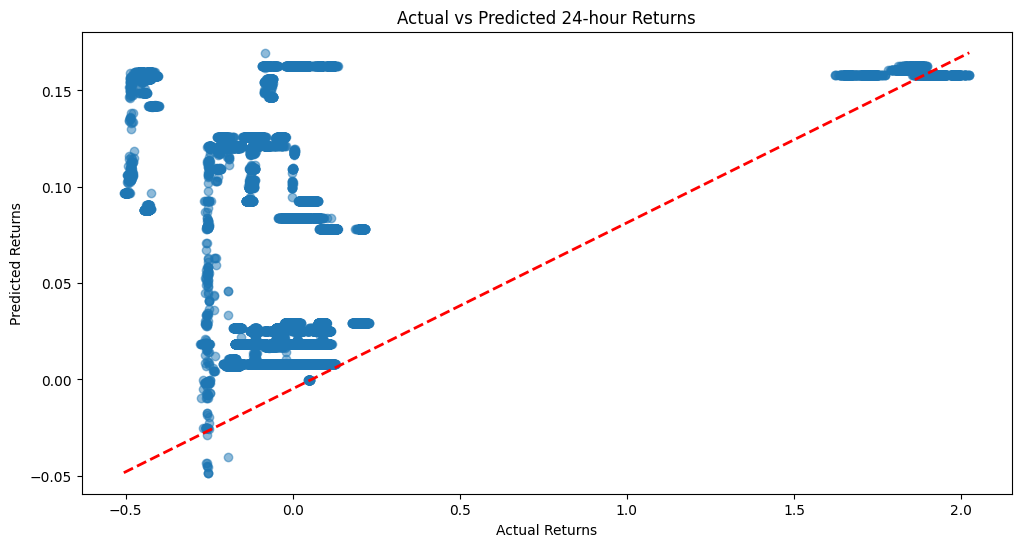

In [340]:

# Evaluate on the test set
y_pred = random_search.predict(X_test)
best_model = random_search.best_estimator_
rf_model = best_model.named_steps['model']


mse = mean_squared_error(y_test, y_pred)
print(f"Test Set MSE: {mse:.2f}")

# Feature importance
# After fitting, extract the fitted OneHotEncoder
onehot_encoder = random_search.best_estimator_.named_steps['preprocess'].named_transformers_['cat']

# Get the one-hot encoded feature names (based on known categories)
categorical_feature_names = onehot_encoder.get_feature_names_out(['weekday', 'month', 'day', 'Cycle'])
continuous_feature_names = ['log_return', 'volatility', 'volume_ma_perc', 'volume_vol',
                            'monthly_ma_perc', 'weekly_ma_perc', 'daily_ma_perc']

all_feature_names = list(categorical_feature_names) + continuous_feature_names

feature_importance = pd.DataFrame({'feature': all_feature_names, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance.head(10))

# Visualize predictions vs actual
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'r--', lw=2)
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Actual vs Predicted 24-hour Returns")
plt.show()


Sem muita surpresa, este não foi um resultado incrível. Com mais tempo testando outros modelos e parâmetros e adicionando dados além do preço e volume, é possível chegar a resultados melhores, mas para chegar em resultados realmente úteis, é preciso muito mais dedicação e provavelmente até uma mudança de escopo, dependendo dos objetivos e resultados chave.

Mas como vimos antes, a sazonalidade é importante no Bitcoin. Não à toa que o mês 9 foi a feature mais importante. Na análise anterior vimos que setembro foi o mês com menos variância, o que limita o erro na previsão do modelo. Em seguida, a razão preço/média móvel diária e mensal aparecem como segunda e terceira features mais importantes, o que também faz sentido, pois elass extraem informações sobre a tendência do preço no curto prazo e num prazo um pouco maior.

Para a Bipa, caso um modelo melhor mas com este espírito seja criado, ele poderia ajudar clientes a escolher melhores momentos para comprar Bitcoin e para a Bipa, poderia ajudar na tesouraria da empresa.


#### **BONUS**!

Como dito antes, é muito difícil fazer uma predição das próximas 24h, especialmente usando apenas a série histórica de preços. Segundo a Hipótese dos Mercados Eficientes (forte), é impossível fazer esse tipo de previsão de forma consistente apenas com dados fornecidos.

Entretanto, para complementar resolvi trazer um modelo que consegue extrair o preço futuro implícito do mercado de opções. Usando a Teoria das Opções, é possível extrair as probabilidades que o mercado está usando para precificar um determinado ativo. Usando isso com os dados públicos da Deribit, é possível descobrir o que "o mercado está pensando" para a distribuição de preços futura do Bitcoin e se posicionar de acordo.

In [342]:
from implied_return import ImpliedReturn

ir = ImpliedReturn(asset='BTC')
# Pega a lista de datas possíveis de vencimento de opções para calcular a distribuição de probabilidade de preços
ir.get_expiry_date()


/Users/breno/Documents/code/SpiritOfSatoshi/ragtest/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.deribit.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


array(['18OCT24', '27DEC24', '1NOV24', '28MAR25', '8NOV24', '26SEP25',
       '25OCT24', '29NOV24', '20OCT24', '19OCT24', '27JUN25'],
      dtype=object)

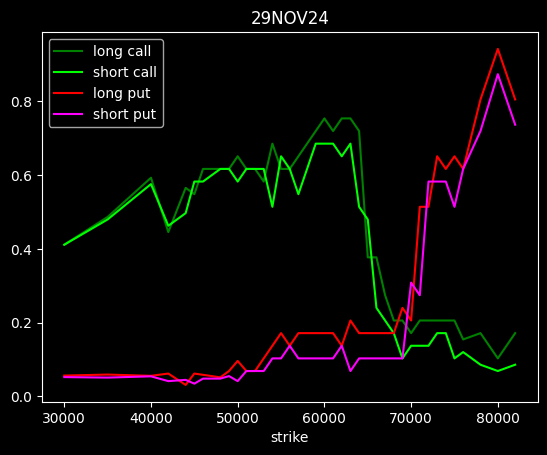

In [343]:
# Gera a distribuição de probabilidade de preços para a data 
ir.butterflies('29NOV24')

Essa é a distribuição de probabilidade de preços do Bitcoin que o mercado está precificando hoje no mercado de opções. Ela em si não é uma previsão minha, mas ela pode trazer informações sobre o futuro do mercado que ainda não chegaram a nós, pois ela é a previsão do mercado como um todo.

Esse gráfico mostra que o mercado ainda não está precificando uma subida do bitcoin acima dos 70k até o final de novembro e que o mercado considera a probabilidade igual do preço ficar entre 45k e 55k, caso caia. Mas a maior probabilidade mesmo é de continuar em torno de 62k.

### Parte 3: Detecção de Anomalias

3.1 Implemente um algoritmo para detectar anomalias nos dados de preço ou volume do Bitcoin.

3.2 Explique sua abordagem e os critérios usados para identificar anomalias.

3.3 Visualize as anomalias detectadas de uma maneira que seja fácil de entender para stakeholders não técnicos.

3.4 Discuta como a detecção de anomalias poderia ser usada para identificar possíveis manipulações de mercado ou outros eventos importantes.



In [381]:
# Feature engineering
df['log_return'] = np.log(df['Close'] / df['Close'].shift(24*60))
df['volatility'] = df['log_return'].rolling(window=24*60).std()
df['volume_ma'] = df['Volume_usd'].rolling(window=24*60).mean()
df['volume_ma_perc'] = df['volume_ma'] / df['log_volume_usd']
df['volume_vol'] = df['Volume'].rolling(window=24*60).std()
df['monthly_ma'] = df['Close'].rolling(window=30*24*60).mean()
df['monthly_ma_perc'] = df['monthly_ma'] / df['Close']
df['weekly_ma'] = df['Close'].rolling(window=7*24*60).mean()
df['weekly_ma_perc'] = df['weekly_ma'] / df['Close']
df['daily_ma'] = df['Close'].rolling(window=24*60).mean()
df['daily_ma_perc'] = df['daily_ma'] / df['Close']

In [382]:
df.isna().sum()

Timestamp                   0
Open                        0
High                        0
Low                         0
Close                       0
Volume                      0
Volume_usd                  0
log_close                   0
log_volume_usd              0
Volume_usd_daily            0
log_volume_usd_daily        0
month                       0
day                         0
weekday                     0
hour                        0
minute                      0
Cycle                       0
ATH_cycle                   0
log_return               1440
volatility               2879
volume_ma                1439
volume_ma_perc           1439
volume_vol               1439
monthly_ma              43199
monthly_ma_perc         43199
weekly_ma               10079
weekly_ma_perc          10079
daily_ma                 1439
daily_ma_perc            1439
dtype: int64

In [386]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

df.dropna(inplace=True)

# Define features and target
features = ['log_return', 'volatility', 
            'monthly_ma_perc', 'weekly_ma_perc', 'daily_ma_perc',
            'weekday', 'month', 'day', 'Cycle']
X = df[features]

# One-Hot Encoding for categorical features
X_encoded = pd.get_dummies(X, columns=['weekday', 'month', 'day', 'Cycle'], drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Fit Isolation Forest
model = IsolationForest(contamination=0.001, random_state=42)  
model.fit(X_scaled)

# Predict anomalies
df['Anomaly'] = model.predict(X_scaled)  # Anomalies will be labeled as -1

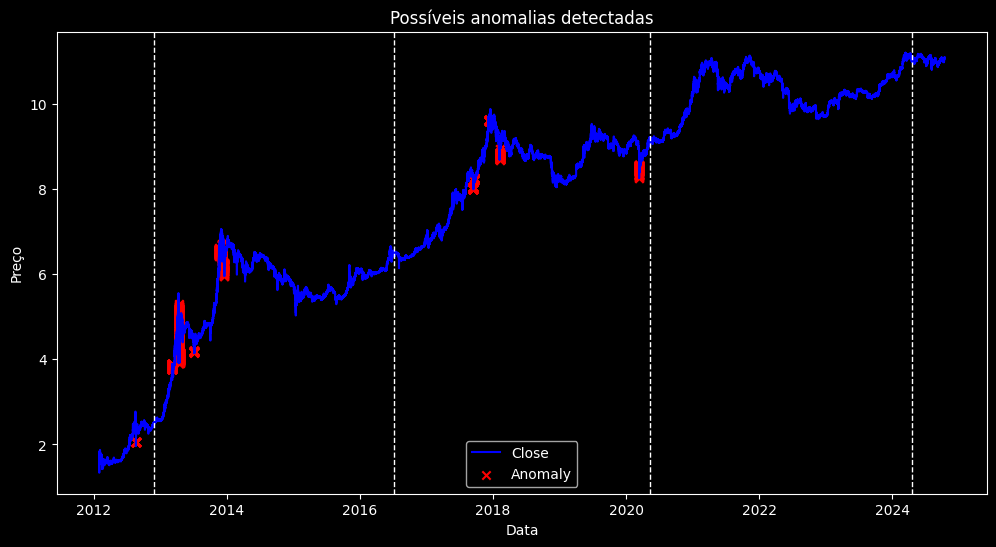

In [392]:
# Visualize anomalies
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df['Timestamp'], df['log_close'], label='Close', color='blue')
ax1.scatter(df[df['Anomaly'] == -1]['Timestamp'], df[df['Anomaly'] == -1]['log_close'], color='red', label='Anomaly', marker='x')
# Adding vertical lines for each cycle change
for cycle_change in df[df['Cycle'].diff() != 0]['Timestamp'].iloc[1:]:
    ax1.axvline(x=cycle_change, color='white', linestyle='--', linewidth=1)

ax1.set_title('Possíveis anomalias detectadas')
ax1.set_xlabel('Data')
ax1.set_ylabel('Preço')
ax1.legend()
plt.show()


O algoritmo de detecção de anomalias é o Isolation Forest. Este é um método não-supervisionado para encontrar outliers em dados. Ele é baseado em uma técnica de ensemble aplicada a árvores de decisão. De forma simples, ele vai aleatoriamente dividindo os dados em dois e gerando árvores, até os últimos pontos serem isolados. Qão mais rápido esses pontos são isolados, maior a chance de ser uma anomalia. Obviamente, como usa a aleatoriedade, para evitar um mínimo local é usada um ensemble (por isso floresta), e os pontos que são isolados com mais frequência tem chances maiores de serem anomalias.

As anomalias foram detectadas a partir das features e, por ser um modelo não supervisionado e por não termos dados de comparação, não temos muito controle sobre os resultados com exceção do parâmetro `contamination`, que é a sensibilidade de detecção de anomalias. Sem um escopo bem definido do que estamos procurando, e possívelmente alguns exemplos, este exercício não passa disto: um exercício. 

Ajustei o parâmetro para 0.001 para ter um número pequeno de anomalias. É interessante observar que a maioria dos pontos anômalos são do início da história do Bitcoin. Isso faz sentido, pois era realmente um momento muito diferente do resto da história do ativo – volatilidade muito mais alta, volume pequeno, discontinuidades, dois picos no ciclo são alguns dos exemplos que tornam esse período muito mais díspare. 

Outro momento marcante é justamente o crash do Covid em 2020. Esta queda é visível até hoje no gráfico e foi capturado como um anomalia pelo modelo. Outros momentos de 2017 e 2018 podem extar indicando momentos de euforia e medo extremo dessa época.

Dificilmente pode se encontrar manipulações de mercado simplesmente usando um modelo de detecção de anomalias somente no preço e volume de um ativo. Entretanto, é muito possível quando se usa mais dados como o livro de ordens de mercado e outros dados. No meu artigo "As Corretoras Brasileiras de Criptomoedas Falsificam Volume de Bitcoin?", publicado em 2018, eu mostrei como a finada NegocieCoins estava tentando manipular o mercado usando dados falsos de volume para atrair traders e investidores incautos.